## TC 5033
### Word Embeddings

<br>

#### Activity 3a: Exploring Word Embeddings with GloVe and Numpy
<br>

- Objective:
    - To understand the concept of word embeddings and their significance in Natural Language Processing.
    - To learn how to manipulate and visualize high-dimensional data using dimensionality reduction techniques like PCA and t-SNE.
    - To gain hands-on experience in implementing word similarity and analogies using GloVe embeddings and Numpy.
    
<br>

- Instructions:
    - Download GloVe pre-trained vectors from the provided link in Canvas, the official public project: 
    Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation
    https://nlp.stanford.edu/data/glove.6B.zip

    - Create a dictorionay of the embeddings so that you carry out fast look ups. Save that dictionary e.g. as a serialized file for faster loading in future uses.
    
    - PCA and t-SNE Visualization: After loading the GloVe embeddings, use Numpy and Sklearn to perform PCA and t-SNE to reduce the dimensionality of the embeddings and visualize them in a 2D or 3D space.

    - Word Similarity: Implement a function that takes a word as input and returns the 'n' most similar words based on their embeddings. You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

    - Word Analogies: Implement a function to solve analogies between words. For example, "man is to king as woman is to ____". You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

    - Submission: This activity is to be submitted in teams of 3 or 4. Only one person should submit the final work, with the full names of all team members included in a markdown cell at the beginning of the notebook.
    
<br>

- Evaluation Criteria:

    - Code Quality (40%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity.
    
   - Functionality (60%): All functions should work as intended, without errors.
       - Visualization of PCA and t-SNE (10% each for a total of 20%)
       - Similarity function (20%)
       - Analogy function (20%)
|



# Integrantes del equipo:

*   Oscar Villa Cardenas - A01794052
*   Diego Alberto Olarte Mira - A01794028
*   Erick Alexei Cambray Servín - A01794243
*   Andres Javier Galindo Vargas - A01793927

#### Import libraries

In [7]:
# Import libraries
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn.functional as F
from numpy.linalg import norm
from pylab import rcParams
from scipy import spatial
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.style.use('ggplot')


#### Load file

In [8]:
# PATH = '/media/pepe/DataUbuntu/Databases/glove_embeddings/glove.6B.200d.txt'
#PATH = '/media/pepe/DataUbuntu/Databases/glove_embeddings/glove.6B.50d.txt'
PATH = 'data/glove.6B.50d.txt'
emb_dim = 50


In [9]:
import requests
import os
import zipfile

url = "https://nlp.stanford.edu/data/glove.6B.zip"
response = requests.get(url)

if response.status_code == 200:
    # Get the filename from the URL
    filename = os.path.basename(url)

    # Save the zip file to the current directory
    zip_file_path = os.path.join(os.getcwd(), filename)
    with open(zip_file_path, "wb") as f:
        f.write(response.content)

    # Unzip the zip file
    with zipfile.ZipFile(zip_file_path, "r") as zip_file:
        zip_file.extractall(os.getcwd())

    # Print a message to indicate that the download and unzip were successful
    print("Data downloaded and unzipped successfully to {}".format(os.getcwd()))

else:
    # Print an error message if the response was not successful
    print("Error downloading data: {}".format(response.status_code))


Data downloaded and unzipped successfully to c:\Users\Tuhabi\Documents\MNA\AdvancedML_Team\semana7


# Embeddings dictionary

In [10]:

def create_emb_dictionary(path):

    dict = {}
    with open(path, 'r', encoding="utf8") as f:
        for line in f:
            lineSplitted = line.split()
            word = lineSplitted[0]
            vector = np.asarray(lineSplitted[1:], "float32")
            dict[word] = vector

    return dict


In [11]:
# create dictionary
embeddings_dict = create_emb_dictionary(PATH)


## Serealization of the model

In [12]:
# Serialize
with open('embeddings_dict_50D.pkl', 'wb') as f:
    pickle.dump(embeddings_dict, f)

# Deserialize
# with open('embeddings_dict_200D.pkl', 'rb') as f:
#     embeddings_dict = pickle.load(f)


#### See some embeddings

In [13]:
def show_n_first_words(dict, n_words):
    keys = list(dict.keys())[0:n_words]
    for k in keys:
        print('The Word is: ', k)
        print("The embbeding is: ", dict[k])



In [14]:
show_n_first_words(embeddings_dict, 2)


The Word is:  the
The embbeding is:  [ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
 -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01
 -1.1514e-01 -7.8581e-01]
The Word is:  ,
The embbeding is:  [ 0.013441  0.23682  -0.16899   0.40951   0.63812   0.47709  -0.42852
 -0.55641  -0.364    -0.23938   0.13001  -0.063734 -0.39575  -0.48162
  0.23291   0.090201 -0.13324   0.078639 -0.41634  -0.15428   0.10068
  0.48891   0.31226  -0.1252   -0.037512 -1.5179    0.12612  -0.02442
 -0.042961 -0.28351   3.5416   -0.1195

See random words of the embeddings

In [15]:
def random_words(dict, n_words):
    keys = np.random.choice(list(dict.keys()), n_words)
    for k in keys:
        print('The Word is: ', k)
        print("The embbeding is: ", dict[k])

random_words(embeddings_dict, 4)


The Word is:  cornificia
The embbeding is:  [ 0.17375    0.64664    0.23082   -0.46907   -0.60841    1.0466
  0.38238    1.0338     0.21797    0.28613    0.54572    0.015746
  0.085608  -0.10786   -0.58061    0.23461   -1.1426    -0.49401
  0.85114    0.53989   -0.42819   -0.0023899 -0.038671   0.066404
  0.52642    0.94448    0.11086    0.26293   -0.27021   -0.64066
 -1.9045     0.31289    1.432      0.17238   -0.32742   -0.45355
  0.54332    0.14645    0.061705   0.59963    0.7223    -0.68824
 -0.15803   -0.13363    0.50786   -0.82537   -0.42974   -0.48839
 -0.28315    0.32292  ]
The Word is:  molave
The embbeding is:  [ 0.39644   -0.54625    0.24796   -0.25447   -0.54498   -0.45599
  0.24688    0.45687    0.48546   -0.056755  -0.1484     0.10414
  0.87568    0.63597   -0.53717    0.23624    0.0019551  0.29232
  0.16439    0.071728  -0.19475   -0.94174    0.024555  -0.41636
  0.73914    1.1584    -0.24615    0.87484    0.52052    0.063245
 -0.72938   -0.20153    0.52198    0.11635   

# Visualizations in 2D

In [44]:
words= ['burger', 'tortilla', 'bread', 'pizza', 'beef', 'steak', 'fries', 'chips',
            'argentina', 'mexico', 'spain', 'usa', 'france', 'italy', 'greece', 'china',
            'water', 'beer', 'tequila', 'wine', 'whisky', 'brandy', 'vodka', 'coffee', 'tea',
            'apple', 'banana', 'orange', 'lemon', 'grapefruit', 'grape', 'strawberry', 'raspberry',
            'school', 'work', 'university', 'highschool']


One function for both

In [45]:
def plot_word_embeddings(words, embedding_model, func, n_components):
  """Plots word embeddings using a given function (PCA or t-SNE) and number of dimensions.

  Args:
    embedding_model: A dictionary of the embedding model.
    func: A function to use to reduce the dimensionality of the word vectors, either PCA or t-SNE.
    n_components: The number of dimensions to plot.

  Returns:
    None.
  """

  # Get the word vectors.
  word_vectors = np.array([embedding_model[word] for word in words])

  # Reduce the dimensionality of the word vectors.
  reduce_model = func(n_components=n_components)
  reduced_word_vectors = reduce_model.fit_transform(word_vectors)

  # Plot the word vectors.
  plt.figure(figsize=(10, 10))
  sns.scatterplot(
    x=reduced_word_vectors[:, 0],
    y=reduced_word_vectors[:, 1],
    c='blue',
    alpha=0.8,
  )

  # Label the points with the word names.
  for label,x,y in zip(words,reduced_word_vectors[:,0],reduced_word_vectors[:,1]):
        plt.annotate(
            label,
            xy=(x,y),
            xytext=(-14, 14),
            textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
        )


  plt.title(str(func.__name__) +' representation for Word Embedding')
  plt.show()




## TSNE
We can clearly see is the best way to demostrate the aggregation of this embeddig as we can see de differnt categories clearly

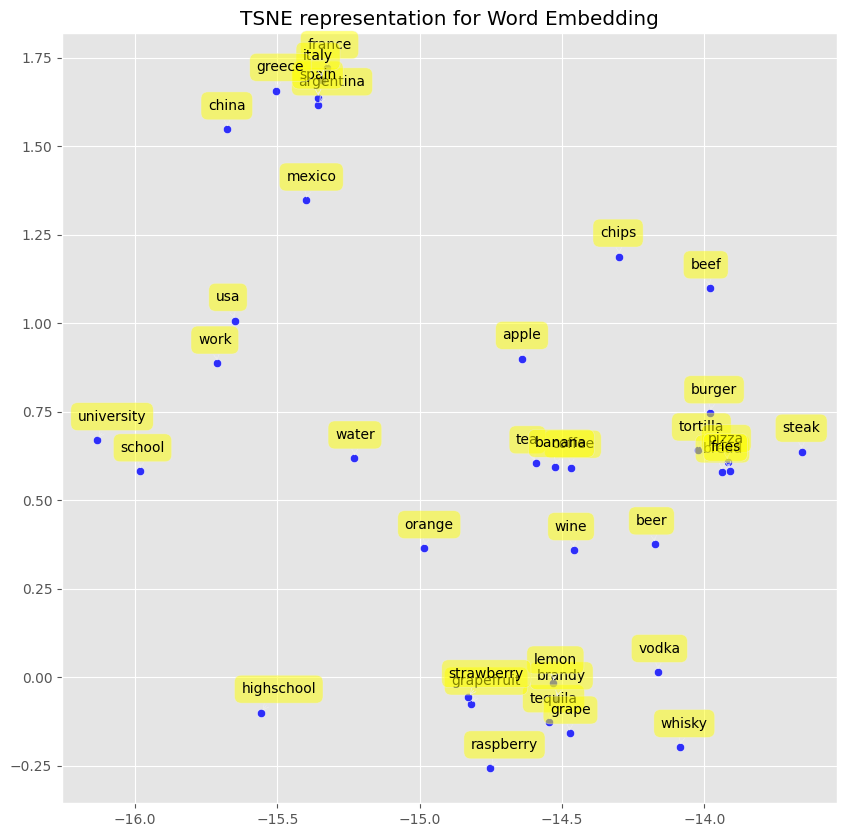

In [46]:
plot_word_embeddings(words=words, embedding_model=embeddings_dict, func=TSNE, n_components=2)


## PCA


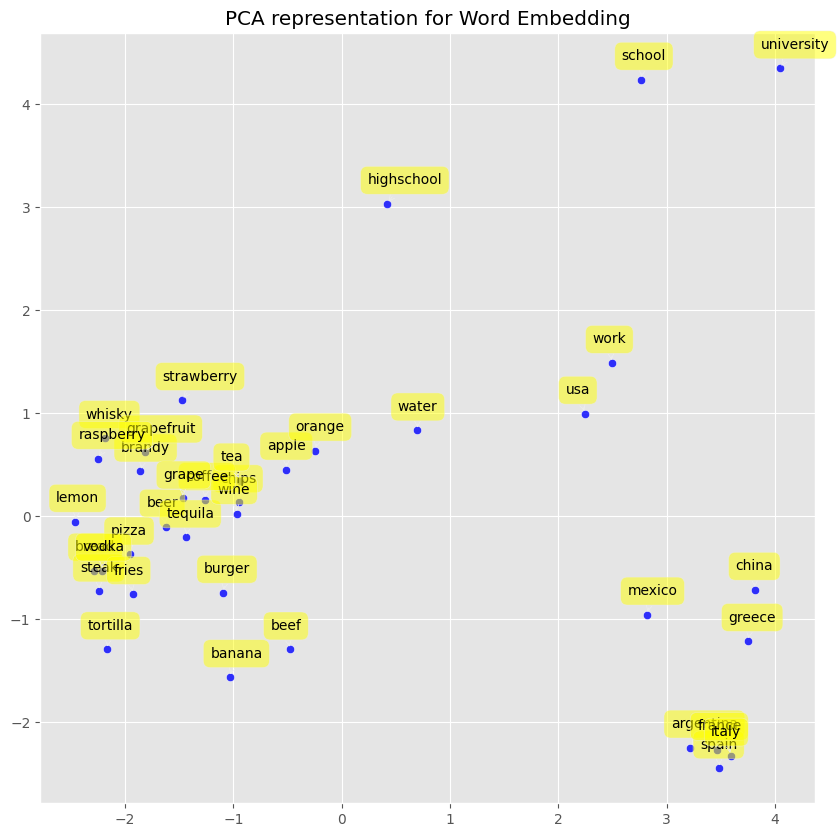

In [47]:
plot_word_embeddings(words=words, embedding_model=embeddings_dict, func=PCA, n_components=2)


### Let us compute analogies

In [48]:
def cos_sim(u,v):
    """
    u: vector of 1st word
    v: vector of 2nd Word
    """
    numerator_ = u.dot(v)
    denominator_= np.sqrt(np.sum(np.square(u))) * np.sqrt(np.sum(np.square(v)))
    return numerator_/denominator_


In [49]:
# analogy
def analogy(word1, word2, word3, embeddings_dict):
    #BEFORE pass
    """
    """
    word_list = embeddings_dict.keys()
    max_sim = -1000
    #Make Sure they are lower
    word1,word2,word3 = word1.lower(),word2.lower(),word3.lower()
    diff_vec = embeddings_dict[word3] - (embeddings_dict[word1]-embeddings_dict[word2]) #word3 - (word1 - word2)
    for word in word_list:
        vec = embeddings_dict[word]
        sim_ = cos_sim(u=diff_vec,v=vec)
        if sim_ > max_sim:
            max_sim = sim_
            word_selected =  word

    return word_selected


In [50]:
analogy('man', 'king', 'woman', embeddings_dict)


'king'

In [51]:
def find_most_similar(words, embeddings_dict, top_n=10):

    return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embeddings_dict[words]))[:top_n]


In [52]:
most_similar = find_most_similar('mexico', embeddings_dict)


In [53]:
for i, w in enumerate(most_similar, 1):
    print(f'{i} ---> {w}')


1 ---> mexico
2 ---> venezuela
3 ---> peru
4 ---> mexican
5 ---> chile
6 ---> colombia
7 ---> puerto
8 ---> rico
9 ---> guatemala
10 ---> panama
